# Install packages

In [2]:
#pip install xgboost 

In [3]:
#pip install shap 

In [4]:
#pip install dcurves 

# Import packages

In [5]:
# import packages
import pandas as pd # Load and manipulate data and for one-hot encoding
import numpy as np # Calculate the mean and standard deviation
import re # used for regular expressions
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer  # Multiple imputation
from sklearn.preprocessing import StandardScaler # Data normalization
from sklearn.linear_model import LogisticRegression # For categorical variables in multiple imputation
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split # Split data into training and testing sets
from sklearn.model_selection import GridSearchCV # Cross validation for tuning hyperparameters
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss # For scoring during model evaluation
from sklearn.calibration import calibration_curve # Calibration plot
from statsmodels.nonparametric.smoothers_lowess import lowess # Enable LOESS smoothing
from sklearn.metrics import confusion_matrix # Create a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # Draw a confusion matrix 
import xgboost as xgb # XGBoost modeling
import shap # Import SHAP library
import matplotlib.pyplot as plt
# To enable the display of the resulting plot in the interface itself
%matplotlib inline 
import seaborn as sns

# Functions defined

## Functions to perform winsorization on data frames

In [6]:
# Function to perform winsorization on multiple series in a data frame
def winso_df(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    '''
    Perform winsorization on selected columns in a DataFrame.

    Parameters:
    df: pd.DataFrame
        The DataFrame containing the data.
    columns: list
        List of column names to be winsorized.

    Returns:
    pd.DataFrame
        DataFrame with winsorized columns.
    '''  
    for column in columns:
        df[column] = winso(df[column])  # Apply winsorization only to non-NaN values
    return df

# Function to perform winsorization on one series
def winso(x: pd.Series, xmin: float = None, xmax: float = None) -> pd.Series:
    '''
    Perform winsorization on a single Series, excluding NaN values.
    
    Parameters:
    x: pd.Series
        A Series of data to be winsorized.
    xmin: float, optional
        Minimum allowable value, if not provided, defaults to 1st percentile.
    xmax: float, optional
        Maximum allowable value, if not provided, defaults to 99th percentile.
    
    Returns:
    pd.Series
        Winsorized Series, with NaNs untouched.
    '''
    # Perform winsorization only on non-NaN values
    non_nan_mask = ~x.isna()  # Mask for non-NaN values
    
    if xmin is None:
        xmin = np.quantile(x[non_nan_mask], 0.01)  # Use non-NaN values to calculate percentiles
    if xmax is None:
        xmax = np.quantile(x[non_nan_mask], 0.99)
    
    # Apply winsorization only to the non-NaN values
    x[non_nan_mask] = np.where(x[non_nan_mask] > xmax, xmax, x[non_nan_mask])
    x[non_nan_mask] = np.where(x[non_nan_mask] < xmin, xmin, x[non_nan_mask])
    
    return x

In [7]:
if False:

    # Function to perform winsorization on multiple series in a data frame
    def winso_df(df: pd.DataFrame, columns: list) -> pd.DataFrame:
        '''
        Perform winsorization on selected columns in a DataFrame.
    
        Parameters:
        df: pd.DataFrame
            The DataFrame containing the data.
        columns: list
            List of column names to be winsorized.
        Returns:
        pd.DataFrame
            DataFrame with winsorized columns.
        '''    
        df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying it in place
        for column in columns:
            df_copy[column] = winso(df_copy[column])
        return df_copy
    
    # Function to perform winsorization on one series
    def winso(x: pd.Series, xmin: float = None, xmax: float = None) -> pd.Series:
        '''
        Perform winsorization on a single Series.
        
        Parameters:
        x: pd.Series
            A Series of data to be winsorized.
        xmin: float, optional
            Minimum allowable value, if not provided, defaults to 1st percentile.
        xmax: float, optional
            Maximum allowable value, if not provided, defaults to 99th percentile.
        
        Returns:
        pd.Series
            Winsorized Series.
        '''
        if xmin is None:
            xmin = np.quantile(x, 0.5)
        if xmax is None:
            xmax = np.quantile(x, 0.5)
        
        x = np.where(x > xmax, xmax, x)
        x = np.where(x < xmin, xmin, x)
        return x

# Import data

In [8]:
df = pd.read_csv(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\original_20240909.csv', sep = ';', decimal = ',')
df

# df.head(5)
# df.dtypes; # ';' prevents the output from being displayed
# df.describe(); # Focus on numerical variables only, excluding NaN (Not a Number) values.
# df.describe(include = 'all'); # Provide full summary statistics
# df.info() # Concise summary of the data frame

,Unnamed: 0,ptcenter,age,sex,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,...,neutro_abs,platelet_abs,dimer,urea,creatinine,crp,pct,ferritin,albumin,ldh
0,1,Klinikum der Universität München,34,male,1.0,1.0,1.0,0.0,0.0,0.0,...,10.800,194.0,32.900000,33.000000,0.80000,21.1,0.30,NaN,590.0,1193.00000
1,2,Jena,71,male,0.0,0.0,0.0,1.0,0.0,0.0,...,4.820,141.0,0.000002,191.180000,0.01000,121.6,0.13,NaN,40.0,14574.15000
2,3,Universitätsklinikum Giessen / Marburg,53,male,0.0,0.0,0.0,0.0,0.0,0.0,...,9.350,303.0,9.760000,34.000000,0.90000,84.9,NaN,NaN,46.6,251.00000
3,4,Universitätsklinikum Frankfurt,63,male,1.0,0.0,NaN,1.0,0.0,1.0,...,NaN,124.0,NaN,65.000000,1.57000,2017.0,NaN,NaN,340.0,555.00000
4,5,Berlin Charité,57,male,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2394,Universitätsmedizin Greifswald,71,female,1.0,0.0,0.0,1.0,1.0,0.0,...,0.724,147.0,2.900000,30.630631,0.90496,59.3,0.10,NaN,NaN,248.95021
2394,2395,Uniklinik Tübingen,77,female,0.0,0.0,1.0,1.0,0.0,0.0,...,0.806,207.0,NaN,NaN,0.60000,101.0,NaN,NaN,NaN,272.00000
2395,2396,Universitätsmedizin Mannheim,43,female,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,181.0,NaN,NaN,0.72000,NaN,NaN,54.0,NaN,NaN
2396,2397,Uniklinik Göttingen,76,female,NaN,NaN,0.0,1.0,1.0,0.0,...,NaN,325.0,NaN,NaN,0.94000,14.0,NaN,49.0,410.0,NaN


# Data cleaning

## Remove duplicates

In [9]:
df = df.drop_duplicates()
df

,Unnamed: 0,ptcenter,age,sex,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,...,neutro_abs,platelet_abs,dimer,urea,creatinine,crp,pct,ferritin,albumin,ldh
0,1,Klinikum der Universität München,34,male,1.0,1.0,1.0,0.0,0.0,0.0,...,10.800,194.0,32.900000,33.000000,0.80000,21.1,0.30,NaN,590.0,1193.00000
1,2,Jena,71,male,0.0,0.0,0.0,1.0,0.0,0.0,...,4.820,141.0,0.000002,191.180000,0.01000,121.6,0.13,NaN,40.0,14574.15000
2,3,Universitätsklinikum Giessen / Marburg,53,male,0.0,0.0,0.0,0.0,0.0,0.0,...,9.350,303.0,9.760000,34.000000,0.90000,84.9,NaN,NaN,46.6,251.00000
3,4,Universitätsklinikum Frankfurt,63,male,1.0,0.0,NaN,1.0,0.0,1.0,...,NaN,124.0,NaN,65.000000,1.57000,2017.0,NaN,NaN,340.0,555.00000
4,5,Berlin Charité,57,male,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2394,Universitätsmedizin Greifswald,71,female,1.0,0.0,0.0,1.0,1.0,0.0,...,0.724,147.0,2.900000,30.630631,0.90496,59.3,0.10,NaN,NaN,248.95021
2394,2395,Uniklinik Tübingen,77,female,0.0,0.0,1.0,1.0,0.0,0.0,...,0.806,207.0,NaN,NaN,0.60000,101.0,NaN,NaN,NaN,272.00000
2395,2396,Universitätsmedizin Mannheim,43,female,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,181.0,NaN,NaN,0.72000,NaN,NaN,54.0,NaN,NaN
2396,2397,Uniklinik Göttingen,76,female,NaN,NaN,0.0,1.0,1.0,0.0,...,NaN,325.0,NaN,NaN,0.94000,14.0,NaN,49.0,410.0,NaN


## Remove unwanted columns

In [10]:
df.columns
df = df.drop(['Unnamed: 0', 'psn', 'comor_chronic_lung_no_asthma'], axis = 1)
df.columns

Index(['ptcenter', 'age', 'sex', 'o2_supplement', 'impaired_consciousness',
       'obesity', 'comor_cvd', 'comor_chronic_lung', 'comor_ckd',
       'comor_chronic_liver', 'num_comor', 'icu_7d', 'death_30d', 'hr',
       'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'lympho_abs',
       'neutro_abs', 'platelet_abs', 'dimer', 'urea', 'creatinine', 'crp',
       'pct', 'ferritin', 'albumin', 'ldh'],
      dtype='object')

## One-hot encoding

In [11]:
# Reference level will not be removed 
df = pd.get_dummies(df, columns = ['sex'])
df.head()

,ptcenter,age,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,comor_chronic_liver,num_comor,...,dimer,urea,creatinine,crp,pct,ferritin,albumin,ldh,sex_female,sex_male
0,Klinikum der Universität München,34,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,32.900000,33.00,0.80,21.1,0.30,NaN,590.0,1193.00,False,True
1,Jena,71,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.000002,191.18,0.01,121.6,0.13,NaN,40.0,14574.15,False,True
2,Universitätsklinikum Giessen / Marburg,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.760000,34.00,0.90,84.9,NaN,NaN,46.6,251.00,False,True
3,Universitätsklinikum Frankfurt,63,1.0,0.0,NaN,1.0,0.0,1.0,0.0,NaN,...,NaN,65.00,1.57,2017.0,NaN,NaN,340.0,555.00,False,True
4,Berlin Charité,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


## Create the variable 'Deterioration'

In [12]:
df['deterioration'] = np.where((df['icu_7d'] == 1) | (df['death_30d'] == 1), 1, 0)
df

,ptcenter,age,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,comor_chronic_liver,num_comor,...,urea,creatinine,crp,pct,ferritin,albumin,ldh,sex_female,sex_male,deterioration
0,Klinikum der Universität München,34,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,33.000000,0.80000,21.1,0.30,NaN,590.0,1193.00000,False,True,1
1,Jena,71,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,191.180000,0.01000,121.6,0.13,NaN,40.0,14574.15000,False,True,0
2,Universitätsklinikum Giessen / Marburg,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.000000,0.90000,84.9,NaN,NaN,46.6,251.00000,False,True,0
3,Universitätsklinikum Frankfurt,63,1.0,0.0,NaN,1.0,0.0,1.0,0.0,NaN,...,65.000000,1.57000,2017.0,NaN,NaN,340.0,555.00000,False,True,1
4,Berlin Charité,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,Universitätsmedizin Greifswald,71,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,...,30.630631,0.90496,59.3,0.10,NaN,NaN,248.95021,True,False,0
2394,Uniklinik Tübingen,77,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,NaN,0.60000,101.0,NaN,NaN,NaN,272.00000,True,False,0
2395,Universitätsmedizin Mannheim,43,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,NaN,0.72000,NaN,NaN,54.0,NaN,NaN,True,False,0
2396,Uniklinik Göttingen,76,NaN,NaN,0.0,1.0,1.0,0.0,0.0,2.0,...,NaN,0.94000,14.0,NaN,49.0,410.0,NaN,True,False,0


## Descriptive statistics for categorical variables

### All patients

In [13]:
df.columns

categorical_cols = ['sex_female', 'sex_male', 'o2_supplement', 'impaired_consciousness', 'obesity', 'comor_cvd', 'comor_chronic_lung', 'comor_ckd', 'comor_chronic_liver', 'icu_7d', 'death_30d', 'deterioration']

df_categoricals = df[categorical_cols]

#df_categoricals.apply(lambda x: (x == 1).sum())

### Subgroups

In [14]:
df_outcomes = ['icu_7d', 'death_30d', 'deterioration']

for outcome in df_outcomes:
    filtered_df = df_categoricals[df_categoricals[outcome] == 1]
    print(f'The current outcome is : {outcome}')
    
    for column in filtered_df.columns:
        print(filtered_df[column].value_counts())
        print(filtered_df[column].value_counts() / filtered_df[column].count())
        print(filtered_df[column].isna().sum())

The current outcome is : icu_7d
sex_female
False    501
True     208
Name: count, dtype: int64
sex_female
False    0.706629
True     0.293371
Name: count, dtype: float64
0
sex_male
True     501
False    208
Name: count, dtype: int64
sex_male
True     0.706629
False    0.293371
Name: count, dtype: float64
0
o2_supplement
1.0    434
0.0    196
Name: count, dtype: int64
o2_supplement
1.0    0.688889
0.0    0.311111
Name: count, dtype: float64
79
impaired_consciousness
0.0    365
1.0    105
Name: count, dtype: int64
impaired_consciousness
0.0    0.776596
1.0    0.223404
Name: count, dtype: float64
239
obesity
0.0    310
1.0    231
Name: count, dtype: int64
obesity
0.0    0.573013
1.0    0.426987
Name: count, dtype: float64
168
comor_cvd
1.0    419
0.0    279
Name: count, dtype: int64
comor_cvd
1.0    0.600287
0.0    0.399713
Name: count, dtype: float64
11
comor_chronic_lung
0.0    496
1.0    193
Name: count, dtype: int64
comor_chronic_lung
0.0    0.719884
1.0    0.280116
Name: count, dtype

## Descriptive statistics for continuous variables

### All patients

In [15]:
df.describe()

df.isna().sum()

ptcenter                     0
age                          0
o2_supplement              169
impaired_consciousness     612
obesity                    536
comor_cvd                   24
comor_chronic_lung          42
comor_ckd                   54
comor_chronic_liver         51
num_comor                  598
icu_7d                       0
death_30d                    0
hr                         192
bp_sys                     156
bp_dia                     157
rr                         581
temp                       236
spo2                       180
wbc_abs                    281
lympho_abs                 918
neutro_abs                 961
platelet_abs               286
dimer                     1180
urea                       735
creatinine                 291
crp                        353
pct                       1091
ferritin                  1410
albumin                   1463
ldh                        671
sex_female                   0
sex_male                     0
deterior

### Subgroups

In [16]:
df_outcomes = ['icu_7d', 'death_30d', 'deterioration']

for outcome in df_outcomes:
    filtered_df = df_categoricals[df_categoricals[outcome] == 1]
    print(f'The current outcome is : {outcome}')
    print(filtered_df.describe())
    print(filtered_df.isna().sum())

The current outcome is : icu_7d
       o2_supplement  impaired_consciousness     obesity   comor_cvd  \
count     630.000000              470.000000  541.000000  698.000000   
mean        0.688889                0.223404    0.426987    0.600287   
std         0.463316                0.416971    0.495098    0.490191   
min         0.000000                0.000000    0.000000    0.000000   
25%         0.000000                0.000000    0.000000    0.000000   
50%         1.000000                0.000000    0.000000    1.000000   
75%         1.000000                0.000000    1.000000    1.000000   
max         1.000000                1.000000    1.000000    1.000000   

       comor_chronic_lung   comor_ckd  comor_chronic_liver  icu_7d  \
count          689.000000  688.000000           690.000000   709.0   
mean             0.280116    0.155523             0.081159     1.0   
std              0.449382    0.362666             0.273278     0.0   
min              0.000000    0.000000  

# Split data into training and test sets (by center locations)

In [17]:
# Define the list of north cities
north_cities = ['Hamburg', 'Berlin', 'Hannover', 'Dashti', 'Duisburg', 'Greifswald', 'Essen', 
                'Dortmund', 'Oldenburg', 'Flensburg', 'Bielefeld', 'Kiel', 'Magdeburg', 
                'Bochum', 'Düsseldorf', 'Göttingen', 'Münster', 'Aachen', 'Leipzig']

# Filter rows where ptcenter matches any of the north cities
df_north = df[df['ptcenter'].str.contains('|'.join(north_cities), na=False, flags=re.IGNORECASE)]

# Filter rows where ptcenter does not match any of the north cities
df_south = df[~df['ptcenter'].str.contains('|'.join(north_cities), na=False, flags=re.IGNORECASE)]

# Rename the datasets for development and validation cohorts
dev_df = df_north  # development cohort
eval_df = df_south  # validation cohort

dev_df = dev_df.drop(['ptcenter'], axis = 1)
eval_df = eval_df.drop(['ptcenter'], axis = 1)

# Model development

## Remove variables missing >= 40%

In [18]:
missing_percentage = dev_df.isna().mean()  # Get percentage of missing values per column
columns_to_drop = missing_percentage[missing_percentage >= 0.4].index  # Get column names with > 40% missing
dev_df = dev_df.drop(columns = columns_to_drop, axis=1)  # Drop those columns (axis=1 for columns)

dev_df.head()

,age,o2_supplement,impaired_consciousness,obesity,comor_cvd,comor_chronic_lung,comor_ckd,comor_chronic_liver,num_comor,icu_7d,...,spo2,wbc_abs,platelet_abs,urea,creatinine,crp,ldh,sex_female,sex_male,deterioration
2,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,95.0,10.60,303.0,34.0,0.90,84.9,251.0,False,True,0
4,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,99.0,NaN,NaN,NaN,NaN,NaN,NaN,False,True,0
5,53,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,...,88.0,2.11,87.0,NaN,0.88,369.0,265.0,False,True,1
6,61,NaN,NaN,1.0,1.0,0.0,0.0,0.0,2.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,1
7,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,True,False,0


## Remove outliers 

In [19]:
# Using percentiles:
 
numerical_cols_winso = ['hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']

dev_df = winso_df(dev_df, numerical_cols_winso)

dev_df_cleaned = dev_df.copy()

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\1480996137.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] > xmax, xmax, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\1480996137.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] < xmin, xmin, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\1480996137.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [20]:
if False:

    # Using IQR to detect outliers
    
    numerical_cols_iqr = ['hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
    
    # Loop through each numerical column and remove outliers
    for col in numerical_cols_iqr:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
        Q1 = dev_df[col].quantile(0.25)
        Q3 = dev_df[col].quantile(0.75)
        
        # Compute IQR for each column
        IQR = Q3 - Q1
        
        # Define outlier boundaries for each column
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers from the current column
        dev_df_cleaned = dev_df[(dev_df[col] >= lower_bound) & (dev_df[col] <= upper_bound)]

## Multiple imputation

In [21]:
# Drop the target columns
dev_df_cleaned.drop(['death_30d', 'deterioration'], axis=1, inplace=True)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_dev_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter=max_iter, random_state=123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter=max_iter, estimator=LogisticRegression(max_iter=1000), random_state=123)

# Perform multiple imputations for continuous variables
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(dev_df_cleaned[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(dev_df_cleaned[categorical_cols_icu])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns=numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns=categorical_cols_icu)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis=1)
    
    # Append the combined DataFrame to the list
    imputed_dev_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_dev_df = pd.concat(imputed_dev_df, ignore_index=True)

## Data normalization

In [22]:
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]

# Initialize the StandardScaler for numeric data
scaler = StandardScaler()

# Fit and transform the numeric columns
scaled_numeric_data = scaler.fit_transform(combined_imputed_dev_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_dev_df = pd.DataFrame(scaled_numeric_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns
standardized_dev_df = pd.concat([scaled_numeric_dev_df.reset_index(drop=True), 
                             combined_imputed_dev_df[categorical_cols_icu].reset_index(drop=True)], axis=1)

# Display the standardized DataFrame
print(standardized_dev_df)

            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -0.336587  -1.467988  0.777591 -0.389075  0.709492  1.072016  0.818824   
1     -0.099155  -1.467988 -0.975263 -0.010500 -0.522770 -1.236146 -0.654822   
2     -0.336587   0.043536  0.965397 -0.226829  0.269398  0.862183  1.498969   
3      0.138277   0.625877 -0.041866  0.059151 -0.001257 -0.004190 -0.010673   
4     -1.464388  -1.467988  0.088970 -0.461120  0.075323 -1.236146  1.385611   
...         ...        ...       ...       ...       ...       ...       ...   
13195 -0.633376   1.672809 -0.474447 -0.929896 -0.610789 -0.882266  1.045539   
13196  1.088004   0.229504 -1.350874 -0.064582 -1.050883 -0.186981 -0.428107   
13197  0.731857   0.625877  0.401980  1.017060  0.445435 -0.396814 -0.201392   
13198  1.028646   0.625877 -2.102097  0.746649 -2.453901 -1.026313 -0.881536   
13199  1.325436  -0.421055 -1.350874 -0.551321 -0.698808 -0.606647 -2.015110   

           spo2   wbc_abs  platelet_abs

## Split the development dataset into features and targets

In [23]:
X_icu = standardized_dev_df.drop(['icu_7d'], axis = 1).copy()

In [24]:
y_icu = standardized_dev_df['icu_7d'].copy()

## Class weighting

In [25]:
if False:
    # Calculate scale_pos_weight: ratio of negative to positive samples in the training data
    neg_count = (y_icu == 0).sum()
    pos_count = (y_icu == 1).sum()
    scale_pos_weight = neg_count / pos_count

## Train the model

In [26]:
param_grid = {
    # Control tree complexity
    'max_depth': [3, 5, 7],  # Retain range, but add a smaller depth for smoother regularization
    'min_child_weight': [1, 3, 5],  # Add an additional value for flexibility

    # Learning rate and boosting iterations
    'learning_rate': [0.05, 0.1],  # Add a smaller learning rate for slower, more precise learning
    'n_estimators': [200, 300],  # Increase the number of estimators since lower learning rates need more boosting rounds

    # Overfitting control
    'subsample': [0.7, 0.8],  # Add a smaller subsample to encourage diversity in trees

    # Regularization parameters (L1 and L2 regularization)
    'reg_alpha': [0, 0.1],  # Introduce L1 regularization to potentially improve feature sparsity
    'reg_lambda': [1, 10],  # Keep this range for L2 regularization

    # Tree-specific parameters
    'colsample_bytree': [0.7, 0.8],  # Add this parameter to explore better feature selection
}

if False:
    # Custom scoring function that combines AUC and Brier score
    def custom_auc_brier(y_true, y_pred_proba):
        auc = roc_auc_score(y_true, y_pred_proba)
        brier = brier_score_loss(y_true, y_pred_proba)
        return 0.5 * auc - 0.5 * brier
    
    # Create custom scorer without 'needs_proba', use 'predict_proba' instead
    custom_scorer = make_scorer(custom_auc_brier, greater_is_better=True, response_method="predict_proba")
    
# Initialize the XGBClassifier
xgb_icu = xgb.XGBClassifier(#scale_pos_weight=scale_pos_weight, 
                            objective='binary:logistic', 
                            seed = 123)

# Using the custom scorer in GridSearchCV
grid_search = GridSearchCV(estimator=xgb_icu, 
                           param_grid=param_grid, 
                           #scoring = 'neg_brier_score',
                           #scoring = 'neg_log_loss',
                           scoring='roc_auc',  # Use the custom scorer
                           #scoring = custom_scorer,
                           cv=5, 
                           verbose=1,
                           n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_icu, y_icu)

# Now you can access the best estimator after fitting
best_xgb_icu = grid_search.best_estimator_

# Extract feature importance from the best model
importances = best_xgb_icu.feature_importances_
feature_names = X_icu.columns

# Create a DataFrame to store feature importances and their names
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance and keep only the top 12 features
top_12_features_fscore_icu = importance_df.sort_values(by='importance', ascending=False).head(12)['feature'].tolist()

print("Top 12 important features: ", top_12_features_fscore_icu)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Top 12 important features:  ['o2_supplement', 'impaired_consciousness', 'ldh', 'bp_dia', 'rr', 'spo2', 'temp', 'crp', 'comor_chronic_lung', 'obesity', 'wbc_abs', 'num_comor']


## Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\2916191586.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)


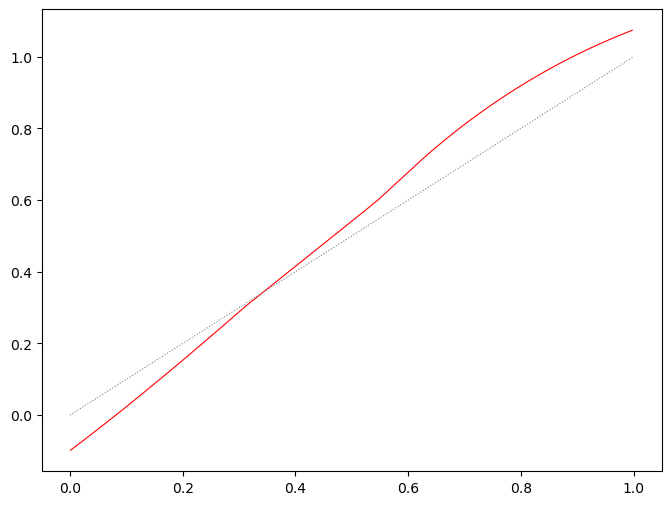

In [27]:
y_icu_pred_proba = best_xgb_icu.predict_proba(X_icu)[:, 1] 

prob_true, prob_pred = calibration_curve(y_icu, y_icu_pred_proba, n_bins=1000)

# Apply LOESS smoothing
loess_fraction = 0.9  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  

## SHAP analysis

Mean SHAP values for features:
                    feature  mean_shap_value_icu
16           o2_supplement             0.919061
4                   bp_dia             0.477440
13                     ldh             0.389832
5                       rr             0.351490
6                     temp             0.305139
12                     crp             0.303904
0                      age             0.279668
7                     spo2             0.277133
8                  wbc_abs             0.240091
1                num_comor             0.240000
11              creatinine             0.224140
10                    urea             0.221727
9             platelet_abs             0.220550
3                   bp_sys             0.202110
17  impaired_consciousness             0.151256
2                       hr             0.150732
20      comor_chronic_lung             0.046771
18                 obesity             0.024661
14              sex_female             0.013201
21      

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\3468734460.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')


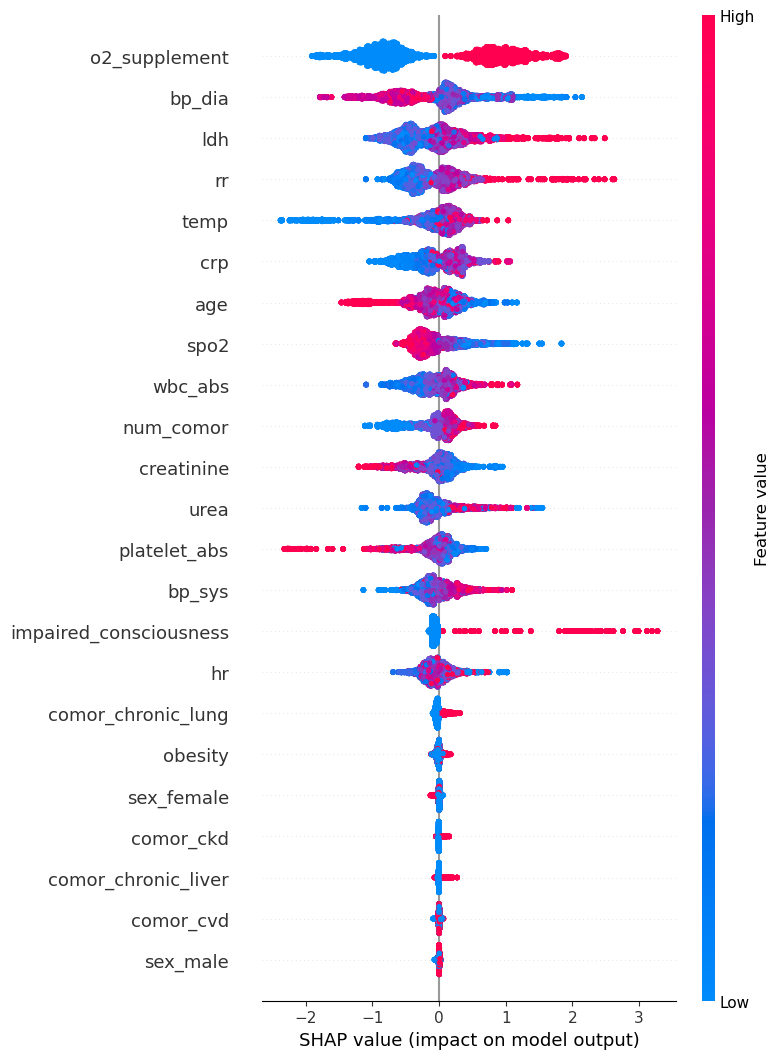

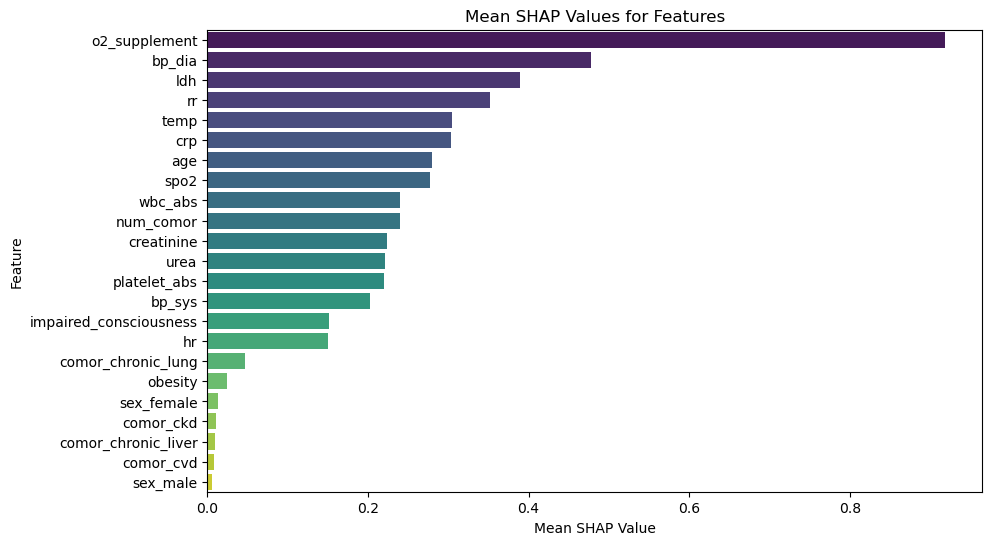

In [28]:
# SHAP values
explainer_icu = shap.TreeExplainer(best_xgb_icu)
shap_values_icu = explainer_icu(X_icu)

# Summary plot
shap.summary_plot(shap_values_icu, X_icu, show = False, max_display=23)

# Calculate mean absolute SHAP values for feature importance
mean_shap_values_icu = pd.DataFrame(list(zip(feature_names, abs(shap_values_icu.values).mean(axis=0))), 
                                 columns=['feature', 'mean_shap_value_icu'])
mean_shap_values_icu = mean_shap_values_icu.sort_values(by='mean_shap_value_icu', ascending=False)

print("Mean SHAP values for features:\n", mean_shap_values_icu)

# Plotting mean SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')
plt.title('Mean SHAP Values for Features')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.show()

# Extract the top 12 features based on mean SHAP values
top_12_features_shap_icu = mean_shap_values_icu['feature'].head(12).tolist()

### One-time SHAP value selection

In [29]:
selected_features_icu = top_12_features_shap_icu

param_grid = {
    # Control tree complexity
    'max_depth': [3, 5, 7],  # Retain range, but add a smaller depth for smoother regularization
    'min_child_weight': [1, 3, 5],  # Add an additional value for flexibility

    # Learning rate and boosting iterations
    'learning_rate': [0.05, 0.1],  # Add a smaller learning rate for slower, more precise learning
    'n_estimators': [200, 300],  # Increase the number of estimators since lower learning rates need more boosting rounds

    # Overfitting control
    'subsample': [0.7, 0.8],  # Add a smaller subsample to encourage diversity in trees

    # Regularization parameters (L1 and L2 regularization)
    'reg_alpha': [0, 0.1],  # Introduce L1 regularization to potentially improve feature sparsity
    'reg_lambda': [1, 10],  # Keep this range for L2 regularization

    # Tree-specific parameters
    'colsample_bytree': [0.7, 0.8],  # Add this parameter to explore better feature selection
}

if False:
    # Custom scoring function that combines AUC and Brier score
    def custom_auc_brier(y_true, y_pred_proba):
        auc = roc_auc_score(y_true, y_pred_proba)
        brier = brier_score_loss(y_true, y_pred_proba)
        return 0.5 * auc - 0.5 * brier
    
    # Create custom scorer without 'needs_proba', use 'predict_proba' instead
    custom_scorer = make_scorer(custom_auc_brier, greater_is_better=True, response_method="predict_proba")

# Initialize the XGBClassifier
xgb_icu = xgb.XGBClassifier(#scale_pos_weight=scale_pos_weight, 
                            objective='binary:logistic', 
                            seed = 123)
    
# Set up the GridSearchCV
grid_search = GridSearchCV(estimator = xgb_icu, 
                           param_grid = param_grid, 
                           #scoring = 'neg_brier_score',
                           scoring = 'roc_auc', 
                           #scoring = custom_scorer, 
                           #scoring = 'neg_log_loss', 
                           cv = 5, 
                           verbose = 1,
                           n_jobs = -1)

X_icu1 = X_icu[selected_features_icu]

# Fit GridSearchCV to the data
grid_search.fit(X_icu1, y_icu)
    
# Now you can access the best estimator after fitting
best_xgb_icu = grid_search.best_estimator_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


### 2nd SHAP selection

#### 2nd training

In [30]:
if False:

    mean_shap_values_icu2 = mean_shap_values_icu[mean_shap_values_icu['mean_shap_value_icu'] > 0.2 * mean_shap_values_icu['mean_shap_value_icu'].max()]
    
    param_grid = {
        # Control tree complexity
        'max_depth': [3, 5, 7],  # Retain range, but add a smaller depth for smoother regularization
        'min_child_weight': [1, 3, 5],  # Add an additional value for flexibility
    
        # Learning rate and boosting iterations
        'learning_rate': [0.05, 0.1],  # Add a smaller learning rate for slower, more precise learning
        'n_estimators': [200, 300],  # Increase the number of estimators since lower learning rates need more boosting rounds
    
        # Overfitting control
        'subsample': [0.7, 0.8],  # Add a smaller subsample to encourage diversity in trees
    
        # Regularization parameters (L1 and L2 regularization)
        'reg_alpha': [0, 0.1],  # Introduce L1 regularization to potentially improve feature sparsity
        'reg_lambda': [1, 10],  # Keep this range for L2 regularization
    
        # Tree-specific parameters
        'colsample_bytree': [0.7, 0.8],  # Add this parameter to explore better feature selection
    }

    # Initialize the XGBClassifier
    xgb_icu = xgb.XGBClassifier(#scale_pos_weight=scale_pos_weight, 
                                objective='binary:logistic', 
                                seed = 123)
    
    # Using the custom scorer in GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_icu, 
                               param_grid=param_grid, 
                               #scoring = 'neg_brier_score',
                               #scoring = 'neg_log_loss',
                               scoring='roc_auc',  # Use the custom scorer
                               #scoring = custom_scorer,
                               cv=5, 
                               verbose=1,
                               n_jobs=-1)
    
    X_icu2 = X_icu[mean_shap_values_icu2['feature'].tolist()]

    # Fit GridSearchCV to the data
    grid_search.fit(X_icu2, y_icu)
    
    # Now you can access the best estimator after fitting
    best_xgb_icu = grid_search.best_estimator_
    
    # Extract feature importance from the best model
    importances = best_xgb_icu.feature_importances_
    feature_names = X_icu2.columns
    
    # Create a DataFrame to store feature importances and their names
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort by importance and keep only the top 12 features
    top_12_features_fscore_icu = importance_df.sort_values(by='importance', ascending=False).head(12)['feature'].tolist()
    
    print("Top 12 important features: ", top_12_features_fscore_icu)

#### 2nd SHAP analysis

In [31]:
if False:

    # SHAP values
    explainer_icu = shap.TreeExplainer(best_xgb_icu)
    shap_values_icu = explainer_icu(X_icu2)
    
    # Summary plot
    shap.summary_plot(shap_values_icu, X_icu2, show = False, max_display=14)
    
    feature_names = mean_shap_values_icu2['feature']
    
    # Calculate mean absolute SHAP values for feature importance
    mean_shap_values_icu = pd.DataFrame(list(zip(feature_names, abs(shap_values_icu.values).mean(axis=0))), 
                                     columns=['feature', 'mean_shap_value_icu'])
    mean_shap_values_icu = mean_shap_values_icu.sort_values(by='mean_shap_value_icu', ascending=False)
    
    print("Mean SHAP values for features:\n", mean_shap_values_icu)
    
    # Plotting mean SHAP values
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')
    plt.title('Mean SHAP Values for Features')
    plt.xlabel('Mean SHAP Value')
    plt.ylabel('Feature')
    plt.show()
    
    # Extract the top 12 features based on mean SHAP values
    top_12_features_shap_icu = mean_shap_values_icu['feature'].head(12).tolist()

#### 2nd SHAP selection

In [32]:
if False:

    selected_features_icu = top_12_features_shap_icu
    
    param_grid = {
        # Control tree complexity
        'max_depth': [3, 5, 7],  # Retain range, but add a smaller depth for smoother regularization
        'min_child_weight': [1, 3, 5],  # Add an additional value for flexibility
    
        # Learning rate and boosting iterations
        'learning_rate': [0.05, 0.1],  # Add a smaller learning rate for slower, more precise learning
        'n_estimators': [200, 300],  # Increase the number of estimators since lower learning rates need more boosting rounds
    
        # Overfitting control
        'subsample': [0.7, 0.8],  # Add a smaller subsample to encourage diversity in trees
    
        # Regularization parameters (L1 and L2 regularization)
        'reg_alpha': [0, 0.1],  # Introduce L1 regularization to potentially improve feature sparsity
        'reg_lambda': [1, 10],  # Keep this range for L2 regularization
    
        # Tree-specific parameters
        'colsample_bytree': [0.7, 0.8],  # Add this parameter to explore better feature selection
    }

    # Initialize the XGBClassifier
    xgb_icu = xgb.XGBClassifier(#scale_pos_weight=scale_pos_weight, 
                                objective='binary:logistic', 
                                seed = 123)
        
    # Set up the GridSearchCV
    grid_search = GridSearchCV(estimator = xgb_icu, 
                               param_grid = param_grid, 
                               #scoring = 'neg_brier_score',
                               scoring = 'roc_auc', 
                               #scoring = custom_scorer, 
                               #scoring = 'neg_log_loss', 
                               cv = 5, 
                               verbose = 1,
                               n_jobs = -1)
    
    X_icu = X_icu[selected_features_icu]
    
    # Fit GridSearchCV to the data
    grid_search.fit(X_icu, y_icu)
        
    # Now you can access the best estimator after fitting
    best_xgb_icu = grid_search.best_estimator_

## F score selection

In [33]:
if False:

    selected_features_icu = top_12_features_fscore_icu
    
    X_icu = X_icu[top_12_features_fscore_icu].copy()  # Features (drop the target column)
        
    # Define the hyperparameter grid
    param_grid = {
        # Control tree complexity
        'max_depth': [3, 5, 7],  # Retain range, but add a smaller depth for smoother regularization
        'min_child_weight': [1, 3, 5],  # Add an additional value for flexibility
    
        # Learning rate and boosting iterations
        'learning_rate': [0.05, 0.1],  # Add a smaller learning rate for slower, more precise learning
        'n_estimators': [200, 300],  # Increase the number of estimators since lower learning rates need more boosting rounds
    
        # Overfitting control
        'subsample': [0.7, 0.8],  # Add a smaller subsample to encourage diversity in trees
    
        # Regularization parameters (L1 and L2 regularization)
        'reg_alpha': [0, 0.1],  # Introduce L1 regularization to potentially improve feature sparsity
        'reg_lambda': [1, 10],  # Keep this range for L2 regularization
    
        # Tree-specific parameters
        'colsample_bytree': [0.7, 0.8],  # Add this parameter to explore better feature selection
    }

    if False:
        # Custom scoring function that combines AUC and Brier score
        def custom_auc_brier(y_true, y_pred_proba):
            auc = roc_auc_score(y_true, y_pred_proba)
            brier = brier_score_loss(y_true, y_pred_proba)
            return 0.5 * auc - 0.5 * brier
        
        # Create custom scorer without 'needs_proba', use 'predict_proba' instead
        custom_scorer = make_scorer(custom_auc_brier, greater_is_better=True, response_method="predict_proba")
        
    # Initialize the XGBClassifier
    xgb_icu = xgb.XGBClassifier(objective='binary:logistic', seed = 123)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator = xgb_icu, 
                               param_grid = param_grid, 
                               #scoring = 'neg_brier_score',
                               scoring = 'roc_auc', 
                               #scoring = custom_scorer, 
                               #scoring = 'neg_log_loss',
                               cv = 5,
                               verbose = 2,
                               n_jobs = -1)

    # Fit GridSearchCV to the data
    grid_search.fit(X_icu, y_icu)
    
    # Now you can access the best estimator after fitting
    best_xgb_icu = grid_search.best_estimator_

## Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\3425069172.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)


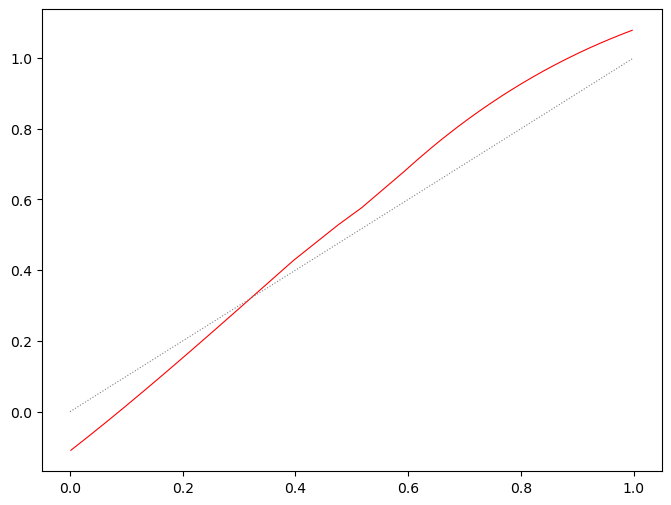

In [34]:
X_icu = X_icu[selected_features_icu]

y_icu_pred_proba = best_xgb_icu.predict_proba(X_icu)[:, 1] 

prob_true, prob_pred = calibration_curve(y_icu, y_icu_pred_proba, n_bins = 1000)

# Apply LOESS smoothing
loess_fraction = 0.9  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)   

# Model evaluation

## Remove variable with missingness >= 40%

In [35]:
missing_percentage = eval_df.isna().mean()
cols_to_drop = missing_percentage[missing_percentage >= 0.4].index
eval_df = eval_df.drop(cols_to_drop, axis = 1)

## Remove outliers

In [36]:
eval_df = winso_df(eval_df, numerical_cols)

eval_df_cleaned = eval_df.copy()

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\1480996137.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] > xmax, xmax, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\1480996137.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[non_nan_mask] = np.where(x[non_nan_mask] < xmin, xmin, x[non_nan_mask])
C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\1480996137.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[34. 71. 63. ... 68. 77. 43.]' has dtype incompati

## Evaluation for ICU

### Multiple imputation

In [37]:
# Drop the target columns
eval_df_icu = eval_df_cleaned.drop(['death_30d', 'deterioration'], axis=1)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_eval_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]

# Store the target variable separately
target_variable = eval_df_icu['icu_7d'] if 'icu_7d' in eval_df_icu.columns else None

# Remove the target variable from categorical columns for imputation
if target_variable is not None:
    categorical_cols_icu.remove('icu_7d')

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter = max_iter, random_state = 123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter = max_iter, estimator=LogisticRegression(max_iter = 1000), random_state = 123)

# Perform multiple imputations
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(eval_df_icu[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(eval_df_icu[categorical_cols_icu])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns = numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns = categorical_cols_icu)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis = 1)
    
    # If the target variable exists, add it back to the combined DataFrame
    if target_variable is not None:
        combined_imputed_df['icu_7d'] = target_variable.values
    
    # Append the combined DataFrame to the list
    imputed_eval_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

In [38]:
if False:

    # Drop the target columns
    eval_df_cleaned.drop(['death_30d', 'deterioration'], axis=1, inplace=True)
    
    # Define number of imputations and iterations
    n_imputations = 10
    max_iter = 10
    
    # Initialize an empty list to hold all imputed datasets
    imputed_eval_df = []
    
    # Define numerical and categorical columns
    numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
    categorical_cols_icu = [col for col in categorical_cols if col not in ['death_30d', 'deterioration']]
    
    # Initialize IterativeImputer for continuous variables with PMM
    pmm_imputer = IterativeImputer(max_iter=max_iter, random_state=123)
    
    # Initialize IterativeImputer for categorical variables with logistic regression
    logreg_imputer = IterativeImputer(max_iter=max_iter, estimator=LogisticRegression(max_iter=1000), random_state=123)

    # Perform multiple imputations for continuous variables
    for i in range(n_imputations):
        # Fit and transform the continuous data
        imputed_numerical = pmm_imputer.fit_transform(eval_df_cleaned[numerical_cols])
        imputed_categorical = logreg_imputer.fit_transform(eval_df_cleaned[categorical_cols_icu])
        
        # Convert to DataFrame and store
        imputed_numerical_df = pd.DataFrame(imputed_numerical, columns=numerical_cols)
        imputed_categorical_df = pd.DataFrame(imputed_categorical, columns=categorical_cols_icu)
        
        # Combine the imputed numerical and categorical DataFrames
        combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis=1)
        
        # Append the combined DataFrame to the list
        imputed_eval_df.append(combined_imputed_df)
    
    # Stack all imputed datasets into one DataFrame
    combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

### Data normalization

In [39]:
categorical_cols_icu.append('icu_7d')

# Apply the same StandardScaler (already fitted on dev_df) to eval_df
scaled_numeric_eval_data = scaler.transform(combined_imputed_eval_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_eval_df = pd.DataFrame(scaled_numeric_eval_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns in eval_df
standardized_eval_df = pd.concat([scaled_numeric_eval_df.reset_index(drop=True), 
                                  combined_imputed_eval_df[categorical_cols_icu].reset_index(drop=True)], axis=1)

# Display the standardized eval DataFrame
print(standardized_eval_df)


            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -1.464388  -0.421055  0.401980  0.259910 -0.346733 -1.236146 -0.428107   
1      0.731857  -0.421055  1.341009  0.962978  1.061566  1.685981  2.745900   
2      0.256993   0.205518 -0.724855 -1.687045 -1.578995  2.540847 -0.994894   
3     -0.158513   1.672809 -0.787457 -0.010500 -0.082677  0.022852  0.932182   
4      0.613141   0.353772 -0.724855 -1.470717 -0.786826 -1.236146 -0.541464   
...         ...        ...       ...       ...       ...       ...       ...   
10775 -0.811450  -1.467988  0.527184 -0.118664  0.093361  0.232685  0.592110   
10776  0.494425  -1.467988  0.589786 -0.983978 -0.698808 -1.026313  0.025323   
10777  0.553783  -0.421055 -0.474447 -0.929896 -0.346733 -0.396814 -1.448323   
10778  1.088004   0.625877 -0.599651 -0.605403 -0.874845  0.022852 -0.314749   
10779 -0.930166  -0.403031 -1.163068  0.151746  0.533454 -0.606647 -1.221609   

           spo2   wbc_abs  platelet_abs

### Split the eval_df into features and target

In [40]:
X_eval_icu = standardized_eval_df.drop(['icu_7d'], axis = 1).copy()  # Features (drop the target column)

X_eval_icu = X_eval_icu[selected_features_icu]

In [41]:
y_eval_icu = standardized_eval_df ['icu_7d'].copy()

### AUC computation

In [42]:
# Predict probabilities on the validation set
y_eval_icu_pred_proba = best_xgb_icu.predict_proba(X_eval_icu)[:, 1]  # Get probabilities for the positive class

# Calculate AUC
auc_score_icu = roc_auc_score(y_eval_icu, y_eval_icu_pred_proba)

print("AUC Score: ", auc_score_icu)

AUC Score:  0.7373042505592842


### Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\3034263068.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration


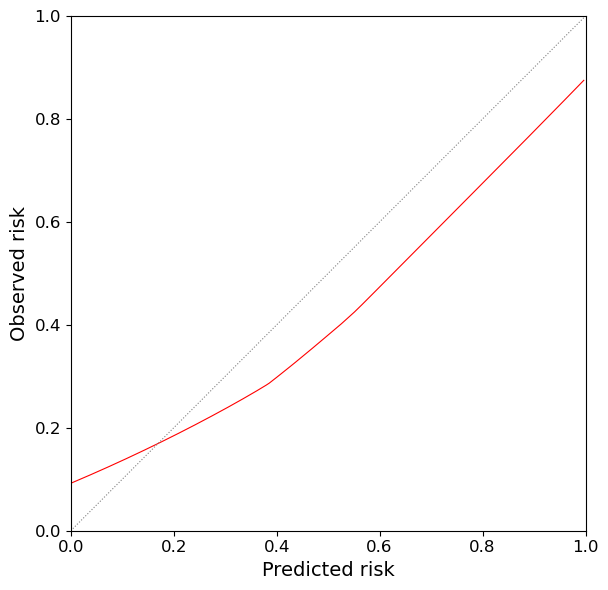

In [43]:
# Compute the calibration curve
prob_true, prob_pred = calibration_curve(y_eval_icu, y_eval_icu_pred_proba, n_bins = 1000)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration

# Set limits and ensure equal unit lengths on both axes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable = 'box')  # This ensures equal scaling of both axes

plt.xlabel('Predicted risk', fontsize = 14)
plt.ylabel('Observed risk', fontsize = 14)
plt.xticks(fontsize = 12)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize = 12)  # Adjust font size for y-axis tick labels
#plt.title('Calibration Plot', fontsize=16)
#plt.legend(loc="best", fontsize = 12)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.grid(False)
plt.savefig(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\results\figures\xgboost_mortality\calibration_plot_12FeaturesbyFscore.png', bbox_inches='tight')
plt.show()


### SHAP analysis

Mean SHAP values for features:
           feature  mean_shap_value_icu
0   o2_supplement             0.822849
1          bp_dia             0.475509
2             ldh             0.433994
3              rr             0.389009
11           urea             0.295767
5             crp             0.294478
9       num_comor             0.293530
4            temp             0.292074
7            spo2             0.282296
8         wbc_abs             0.258990
6             age             0.257351
10     creatinine             0.238857


C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\3872953791.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')


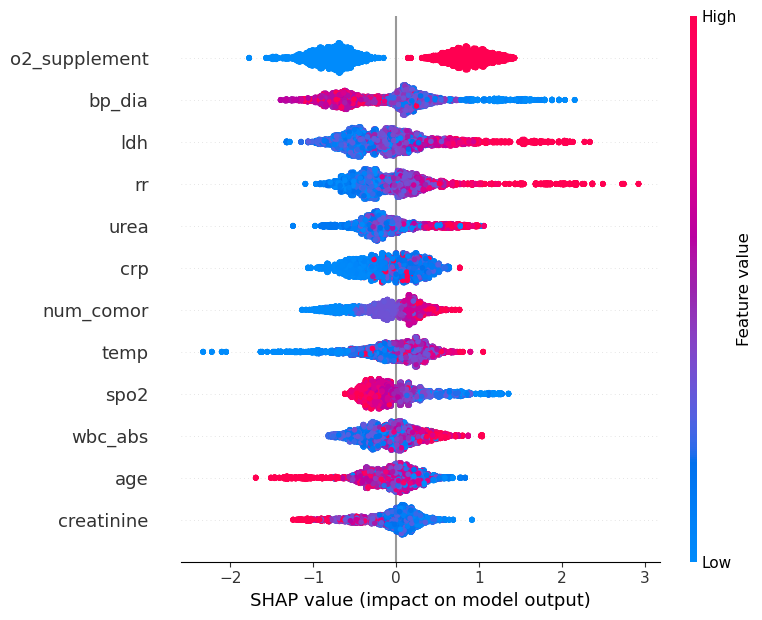

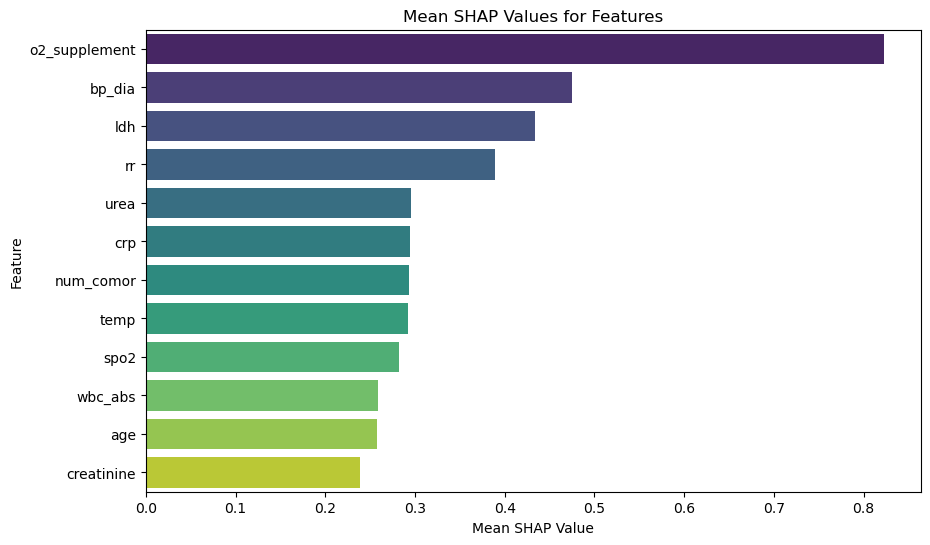

In [44]:
# SHAP values
explainer_icu = shap.TreeExplainer(best_xgb_icu)
shap_values_icu = explainer_icu(X_eval_icu)

# Summary plot
shap.summary_plot(shap_values_icu, X_eval_icu, show = False, max_display=23)

feature_names = X_eval_icu.columns

# Calculate mean absolute SHAP values for feature importance
mean_shap_values_icu = pd.DataFrame(list(zip(feature_names, abs(shap_values_icu.values).mean(axis=0))), 
                                 columns=['feature', 'mean_shap_value_icu'])
mean_shap_values_icu = mean_shap_values_icu.sort_values(by='mean_shap_value_icu', ascending=False)

print("Mean SHAP values for features:\n", mean_shap_values_icu)

# Plotting mean SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_shap_values_icu, x='mean_shap_value_icu', y='feature', palette='viridis')
plt.title('Mean SHAP Values for Features')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.show()

# Extract the top 12 features based on mean SHAP values
top_12_features_shap_icu = mean_shap_values_icu['feature'].head(12).tolist()

## Evaluation for mortality

### Multiple imputation

In [45]:
# Drop the target columns
eval_df_mortality = eval_df_cleaned.drop(['icu_7d', 'deterioration'], axis = 1)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_eval_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_mortality = [col for col in categorical_cols if col not in ['icu_7d', 'deterioration']]

# Store the target variable separately
target_variable = eval_df_mortality['death_30d'] if 'death_30d' in eval_df_mortality.columns else None

# Remove the target variable from categorical columns for imputation
if target_variable is not None:
    categorical_cols_mortality.remove('death_30d')

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter=max_iter, random_state=123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter=max_iter, estimator=LogisticRegression(max_iter=1000), random_state=123)

# Perform multiple imputations
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(eval_df_mortality[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(eval_df_mortality[categorical_cols_mortality])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns=numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns=categorical_cols_mortality)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis=1)
    
    # If the target variable exists, add it back to the combined DataFrame
    if target_variable is not None:
        combined_imputed_df['death_30d'] = target_variable.values
    
    # Append the combined DataFrame to the list
    imputed_eval_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

### Data normalization

In [46]:
categorical_cols_mortality.append('death_30d')

# Apply the same StandardScaler (already fitted on dev_df) to eval_df
scaled_numeric_eval_data = scaler.transform(combined_imputed_eval_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_eval_df = pd.DataFrame(scaled_numeric_eval_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns in eval_df
standardized_eval_df = pd.concat([scaled_numeric_eval_df.reset_index(drop=True), 
                                  combined_imputed_eval_df[categorical_cols_mortality].reset_index(drop=True)], axis=1)

# Display the standardized eval DataFrame
print(standardized_eval_df)

            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -1.464388  -0.421055  0.401980  0.259910 -0.346733 -1.236146 -0.428107   
1      0.731857  -0.421055  1.341009  0.962978  1.061566  1.685981  2.745900   
2      0.256993   0.205518 -0.724855 -1.687045 -1.578995  2.540847 -0.994894   
3     -0.158513   1.672809 -0.787457 -0.010500 -0.082677  0.022852  0.932182   
4      0.613141   0.353772 -0.724855 -1.470717 -0.786826 -1.236146 -0.541464   
...         ...        ...       ...       ...       ...       ...       ...   
10775 -0.811450  -1.467988  0.527184 -0.118664  0.093361  0.232685  0.592110   
10776  0.494425  -1.467988  0.589786 -0.983978 -0.698808 -1.026313  0.025323   
10777  0.553783  -0.421055 -0.474447 -0.929896 -0.346733 -0.396814 -1.448323   
10778  1.088004   0.625877 -0.599651 -0.605403 -0.874845  0.022852 -0.314749   
10779 -0.930166  -0.403031 -1.163068  0.151746  0.533454 -0.606647 -1.221609   

           spo2   wbc_abs  platelet_abs

### Split the eval_df into features and target

In [47]:
X_eval_mortality = standardized_eval_df.drop(['death_30d'], axis = 1).copy()  # Features (drop the target column)

X_eval_mortality = X_eval_mortality[selected_features_icu]

In [48]:
y_eval_mortality = standardized_eval_df ['death_30d'].copy()

### AUC computation

In [49]:
# Predict probabilities on the validation set
y_eval_mortality_pred_proba = best_xgb_icu.predict_proba(X_eval_mortality)[:, 1]  # Get probabilities for the positive class

# Calculate AUC
auc_score_mortality = roc_auc_score(y_eval_mortality, y_eval_mortality_pred_proba)

print("AUC Score: ", auc_score_mortality)

AUC Score:  0.7555150086795657


### Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\879747121.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration


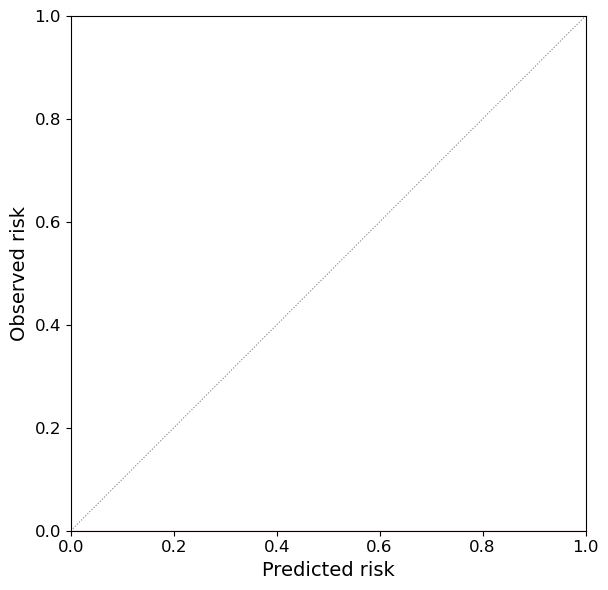

In [50]:
# Compute the calibration curve
prob_true, prob_pred = calibration_curve(y_eval_mortality, y_eval_mortality_pred_proba, n_bins = 1000)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration

# Set limits and ensure equal unit lengths on both axes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable = 'box')  # This ensures equal scaling of both axes

plt.xlabel('Predicted risk', fontsize = 14)
plt.ylabel('Observed risk', fontsize = 14)
plt.xticks(fontsize = 12)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize = 12)  # Adjust font size for y-axis tick labels
#plt.title('Calibration Plot', fontsize=16)
#plt.legend(loc="best", fontsize = 12)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.grid(False)
plt.savefig(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\results\figures\xgboost_mortality\calibration_plot_12FeaturesbyFscore.png', bbox_inches='tight')
plt.show()

### SHAP analysis

Mean SHAP values for features:
           feature  mean_shap_value_mortality
0   o2_supplement                   0.822849
1          bp_dia                   0.475509
2             ldh                   0.433994
3              rr                   0.389009
11           urea                   0.295767
5             crp                   0.294478
9       num_comor                   0.293530
4            temp                   0.292074
7            spo2                   0.282296
8         wbc_abs                   0.258990
6             age                   0.257351
10     creatinine                   0.238857


C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\164123124.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_shap_values_mortality, x='mean_shap_value_mortality', y='feature', palette='viridis')


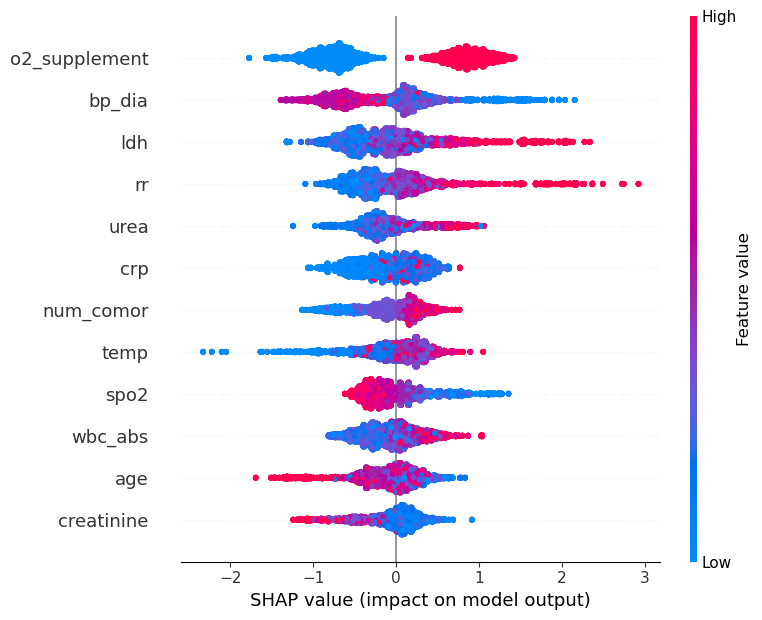

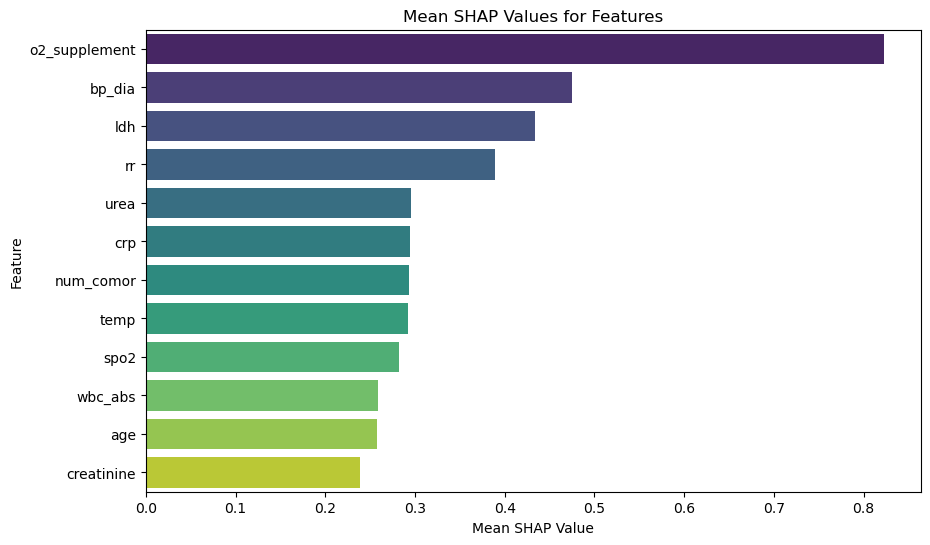

In [51]:
# SHAP values
explainer_mortality = shap.TreeExplainer(best_xgb_icu)
shap_values_mortality = explainer_mortality(X_eval_mortality)

# Summary plot
shap.summary_plot(shap_values_mortality, X_eval_mortality, show = False, max_display=23)

feature_names = X_eval_mortality.columns

# Calculate mean absolute SHAP values for feature importance
mean_shap_values_mortality = pd.DataFrame(list(zip(feature_names, abs(shap_values_mortality.values).mean(axis=0))), 
                                 columns=['feature', 'mean_shap_value_mortality'])
mean_shap_values_mortality = mean_shap_values_mortality.sort_values(by='mean_shap_value_mortality', ascending=False)

print("Mean SHAP values for features:\n", mean_shap_values_mortality)

# Plotting mean SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_shap_values_mortality, x='mean_shap_value_mortality', y='feature', palette='viridis')
plt.title('Mean SHAP Values for Features')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.show()

# Extract the top 12 features based on mean SHAP values
top_12_features_shap_mortality = mean_shap_values_mortality['feature'].head(12).tolist()

## Evaluation for deterioration

### Multiple imputation

In [52]:
# Drop the target columns
eval_df_deterioration = eval_df_cleaned.drop(['death_30d', 'icu_7d'], axis=1)

# Define number of imputations and iterations
n_imputations = 10
max_iter = 10

# Initialize an empty list to hold all imputed datasets
imputed_eval_df = []

# Define numerical and categorical columns
numerical_cols = ['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2', 'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh']
categorical_cols_deterioration = [col for col in categorical_cols if col not in ['death_30d', 'icu_7d']]

# Store the target variable separately
target_variable = eval_df_deterioration['deterioration'] if 'deterioration' in eval_df_deterioration.columns else None

# Remove the target variable from categorical columns for imputation
if target_variable is not None:
    categorical_cols_deterioration.remove('deterioration')

# Initialize IterativeImputer for continuous variables with PMM
pmm_imputer = IterativeImputer(max_iter = max_iter, random_state = 123)

# Initialize IterativeImputer for categorical variables with logistic regression
logreg_imputer = IterativeImputer(max_iter = max_iter, estimator=LogisticRegression(max_iter = 1000), random_state = 123)

# Perform multiple imputations
for i in range(n_imputations):
    # Fit and transform the continuous data
    imputed_numerical = pmm_imputer.fit_transform(eval_df_deterioration[numerical_cols])
    imputed_categorical = logreg_imputer.fit_transform(eval_df_deterioration[categorical_cols_deterioration])
    
    # Convert to DataFrame and store
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns = numerical_cols)
    imputed_categorical_df = pd.DataFrame(imputed_categorical, columns = categorical_cols_deterioration)
    
    # Combine the imputed numerical and categorical DataFrames
    combined_imputed_df = pd.concat([imputed_numerical_df, imputed_categorical_df], axis = 1)
    
    # If the target variable exists, add it back to the combined DataFrame
    if target_variable is not None:
        combined_imputed_df['deterioration'] = target_variable.values
    
    # Append the combined DataFrame to the list
    imputed_eval_df.append(combined_imputed_df)

# Stack all imputed datasets into one DataFrame
combined_imputed_eval_df = pd.concat(imputed_eval_df, ignore_index=True)

In [53]:
combined_imputed_eval_df.columns

Index(['age', 'num_comor', 'hr', 'bp_sys', 'bp_dia', 'rr', 'temp', 'spo2',
       'wbc_abs', 'platelet_abs', 'urea', 'creatinine', 'crp', 'ldh',
       'sex_female', 'sex_male', 'o2_supplement', 'impaired_consciousness',
       'obesity', 'comor_cvd', 'comor_chronic_lung', 'comor_ckd',
       'comor_chronic_liver', 'deterioration'],
      dtype='object')

### Data normalization

In [54]:
categorical_cols_deterioration.append('deterioration')

# Apply the same StandardScaler (already fitted on dev_df) to eval_df
scaled_numeric_eval_data = scaler.transform(combined_imputed_eval_df[numerical_cols])

# Convert the scaled numeric data back to a DataFrame
scaled_numeric_eval_df = pd.DataFrame(scaled_numeric_eval_data, columns = numerical_cols)

# Recombine the standardized numeric columns with the original unchanged categorical columns in eval_df
standardized_eval_df = pd.concat([scaled_numeric_eval_df.reset_index(drop=True), 
                                  combined_imputed_eval_df[categorical_cols_deterioration].reset_index(drop=True)], axis=1)

# Display the standardized eval DataFrame
print(standardized_eval_df)

            age  num_comor        hr    bp_sys    bp_dia        rr      temp  \
0     -1.464388  -0.421055  0.401980  0.259910 -0.346733 -1.236146 -0.428107   
1      0.731857  -0.421055  1.341009  0.962978  1.061566  1.685981  2.745900   
2      0.256993   0.205518 -0.724855 -1.687045 -1.578995  2.540847 -0.994894   
3     -0.158513   1.672809 -0.787457 -0.010500 -0.082677  0.022852  0.932182   
4      0.613141   0.353772 -0.724855 -1.470717 -0.786826 -1.236146 -0.541464   
...         ...        ...       ...       ...       ...       ...       ...   
10775 -0.811450  -1.467988  0.527184 -0.118664  0.093361  0.232685  0.592110   
10776  0.494425  -1.467988  0.589786 -0.983978 -0.698808 -1.026313  0.025323   
10777  0.553783  -0.421055 -0.474447 -0.929896 -0.346733 -0.396814 -1.448323   
10778  1.088004   0.625877 -0.599651 -0.605403 -0.874845  0.022852 -0.314749   
10779 -0.930166  -0.403031 -1.163068  0.151746  0.533454 -0.606647 -1.221609   

           spo2   wbc_abs  platelet_abs

### Split the eval_df into features and target

In [55]:
X_eval_deterioration = standardized_eval_df.drop(['deterioration'], axis = 1).copy()  # Features (drop the target column)

X_eval_deterioration = X_eval_deterioration[selected_features_icu]

In [56]:
y_eval_deterioration = standardized_eval_df ['deterioration'].copy()

### AUC computation

In [57]:
# Predict probabilities on the validation set
y_eval_deterioration_pred_proba = best_xgb_icu.predict_proba(X_eval_deterioration)[:, 1]  # Get probabilities for the positive class

# Calculate AUC
auc_score_deterioration = roc_auc_score(y_eval_deterioration, y_eval_deterioration_pred_proba)

print("AUC Score: ", auc_score_deterioration)

AUC Score:  0.7330756109548531


### Calibration plot

C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\582158002.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration


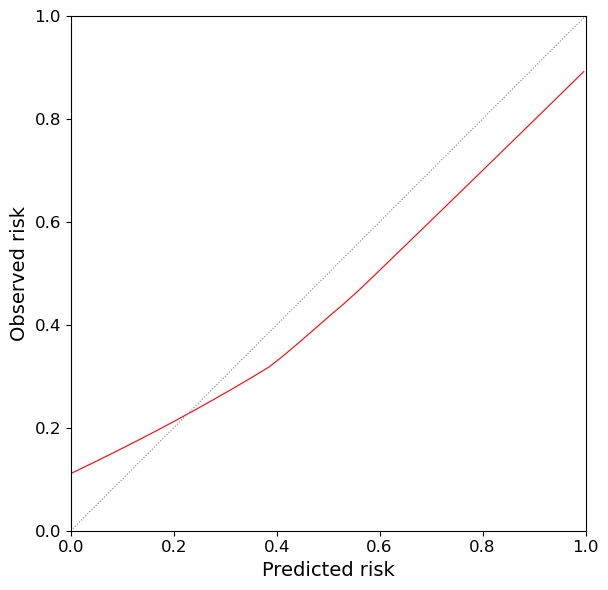

In [64]:
# Compute the calibration curve
prob_true, prob_pred = calibration_curve(y_eval_deterioration, y_eval_deterioration_pred_proba, n_bins = 1000)

# Apply LOESS smoothing
loess_fraction = 0.8  # Adjust this value to change the degree of smoothing
smoothed_values = lowess(prob_true, prob_pred, frac=loess_fraction)

# Extract smoothed x and y values
smoothed_x = smoothed_values[:, 0]
smoothed_y = smoothed_values[:, 1]

# Plot calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot(smoothed_x, smoothed_y, label = 'LOESS Smoothed', color = 'red', linewidth = 0.8)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", color = 'grey', linewidth = 0.8)  # Reference line for perfect calibration

# Set limits and ensure equal unit lengths on both axes
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable = 'box')  # This ensures equal scaling of both axes

plt.xlabel('Predicted risk', fontsize = 14)
plt.ylabel('Observed risk', fontsize = 14)
plt.xticks(fontsize = 12)  # Adjust font size for x-axis tick labels
plt.yticks(fontsize = 12)  # Adjust font size for y-axis tick labels
#plt.title('Calibration Plot', fontsize=16)
#plt.legend(loc="best", fontsize = 12)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.grid(False)
plt.savefig(r'T:\Projects\NAPKON\projects\CROSS_mortality\python\results\figures\xgboost_mortality\calibration_plot_12FeaturesbyFscore.png', bbox_inches='tight')
plt.show()

### SHAP analysis

Mean SHAP values for features:
           feature  mean_shap_value_deterioration
0   o2_supplement                       0.822849
1          bp_dia                       0.475509
2             ldh                       0.433994
3              rr                       0.389009
11           urea                       0.295767
5             crp                       0.294478
9       num_comor                       0.293530
4            temp                       0.292074
7            spo2                       0.282296
8         wbc_abs                       0.258990
6             age                       0.257351
10     creatinine                       0.238857


C:\Users\xiangw\AppData\Local\Temp\ipykernel_11344\1395603523.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_shap_values_deterioration, x='mean_shap_value_deterioration', y='feature', palette='viridis')


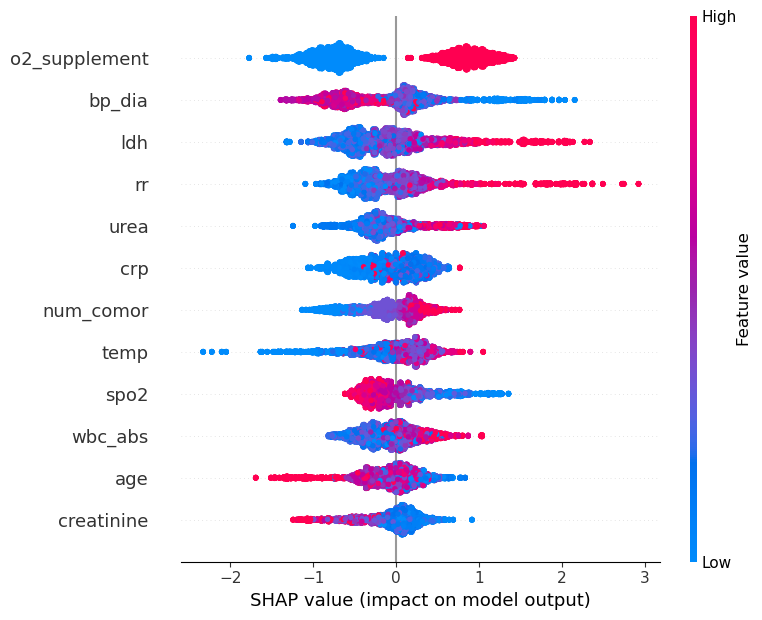

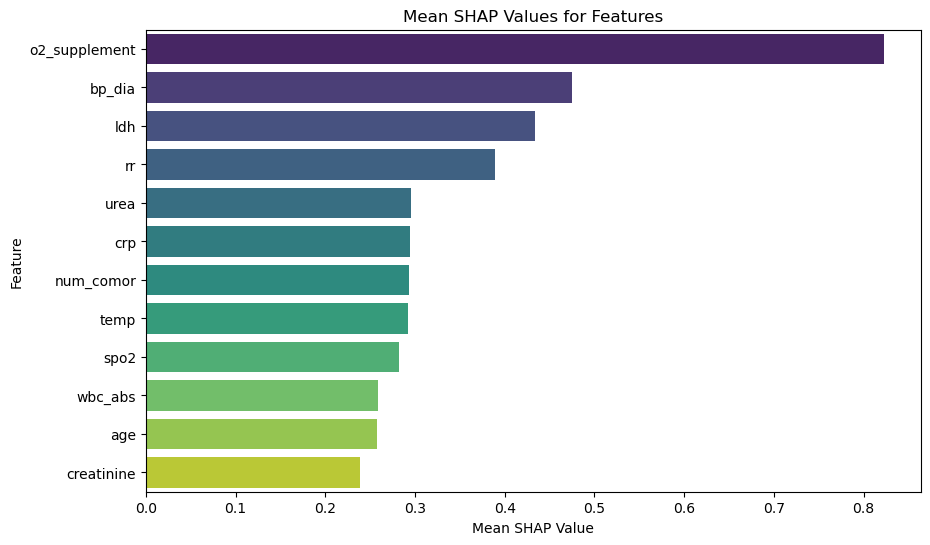

In [59]:
# SHAP values
explainer_deterioration = shap.TreeExplainer(best_xgb_icu)
shap_values_deterioration = explainer_deterioration(X_eval_deterioration)

# Summary plot
shap.summary_plot(shap_values_deterioration, X_eval_deterioration, show = False, max_display=23)

feature_names = X_eval_deterioration.columns

# Calculate mean absolute SHAP values for feature importance
mean_shap_values_deterioration = pd.DataFrame(list(zip(feature_names, abs(shap_values_deterioration.values).mean(axis=0))), 
                                 columns=['feature', 'mean_shap_value_deterioration'])
mean_shap_values_deterioration = mean_shap_values_deterioration.sort_values(by='mean_shap_value_deterioration', ascending=False)

print("Mean SHAP values for features:\n", mean_shap_values_deterioration)

# Plotting mean SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_shap_values_deterioration, x='mean_shap_value_deterioration', y='feature', palette='viridis')
plt.title('Mean SHAP Values for Features')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.show()

# Extract the top 12 features based on mean SHAP values
top_12_features_shap_deterioration = mean_shap_values_deterioration['feature'].head(12).tolist()